# Document and Image Analysis with Amazon Nova 2

Amazon Nova 2 Lite can process documents, images, and video to extract information and answer questions. This notebook demonstrates how to use the Converse API for intelligent document processing (IDP) and image analysis in an insurance claims scenario.

We cover the following topics:

1. **Content summarization** — extracting key insights from a PDF claim form
2. **Structured data extraction** — using a JSON schema to produce structured output from documents
3. **Image analysis and validation** — detecting damage in photos and cross-referencing with claim data

For more details, see the [Multimodal Prompting Best Practices](https://docs.aws.amazon.com/nova/latest/nova2-userguide/prompting-multimodal.html).

### Claim Processing Workflow

```mermaid
flowchart LR
    A["📄 PDF Claim Forms"] --> B["1. Summarize Content"]
    A --> C["2. Extract Structured Data"]
    D["📷 Damage Photos"] --> E["3a. Detect Damage\n(Bounding Boxes)"]
    C --> F["3b. Validate Claim"]
    E --> F
    F --> G["✅ Validation Report"]
```

## Setup

<div class="alert alert-info">
 <b>You will see pip dependency errors, you can safely ignore these errors.</b>
    
    IGNORE ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
</div>

In [ ]:
import boto3
import logging
from IPython.display import IFrame
from IPython.display import display, Image
from botocore.exceptions import ClientError
from pprint import pprint
import json
import os
from glob import glob

In [ ]:
logging.basicConfig(level=logging.INFO,
                    format="%(levelname)s: %(message)s")

In [ ]:
%store -r MODEL_ID
%store -r region_name

## 1. Content Summarization

We use Amazon Nova 2 Lite to process and extract data from PDF insurance claim forms via the Converse API.

A helper function to load documents and send requests to Amazon Bedrock:

In [4]:
def send_document_to_bedrock(prompt, model_id=MODEL_ID, file_path=None, tool_config=None, document_type=None):
    """
    Sends a message to the AWS Bedrock Converse API for processing, optionally including a PDF document.
    This function constructs a message that includes a text prompt and, if provided, a PDF document (as raw bytes)
    read from the specified file system path. It then sends the message to the AWS Bedrock Converse API using the provided
    model ID. Optionally, if a tool configuration is provided via the `tool_config` parameter, it is passed to the API call.
    The API response, which includes the model's output message and associated metadata, is returned.
    Parameters:
        prompt (str): A text prompt that provides context or instructions for processing.
        model_id (str): The identifier of the AWS Bedrock model to use for inference. This model must support document
            inputs. If no model_id is provided, Amazon Nova 2 Lite will be used.
        file_path (str, optional): The file system path to the PDF document. If provided, the PDF will be read and
            included in the message. Defaults to None.
        tool_config (dict, optional): A dictionary specifying the tool configuration to be passed to the Converse API.
            Defaults to None.
        document_type (str): Document type, e.g., pdf, png.
    Returns:
        dict or None: The JSON response from the Bedrock Converse API if the call is successful, containing the model's
        output and metadata; returns None if an error occurs.
    Raises:
        ClientError: If there is an error invoking the AWS Bedrock Converse API.
    """
    # Build the content list with document/image BEFORE the text prompt
    # Best practice: user text prompt should always be the last item in the message
    content_blocks = []
    # If a file path is provided, add the document/image block first
    if file_path is not None:
        with open(file_path, "rb") as f:
            doc_bytes = f.read()
        if document_type == "pdf":
            content_blocks.append({
                "document": {
                    "name": "claim_template",  # Use a neutral name
                    "format": "pdf",  # Supported formats: pdf | csv | doc | docx | xls | xlsx | html | txt | md
                    "source": {
                        "bytes": doc_bytes
                    }
                }
            })
        elif document_type == "png":
            content_blocks.append({
                "image": {
                    "format": "png",
                    "source": {"bytes": doc_bytes},
                }
            })
    # Text prompt always goes last in the content list
    content_blocks.append({"text": prompt})
    # Initialize the Bedrock runtime client
    # Note: 'region_name' should be defined or replaced with your desired AWS region
    bedrock_client = boto3.client("bedrock-runtime", region_name=region_name)
    # Construct the message with the content blocks
    message = {
        "role": "user",
        "content": content_blocks
    }
    # Optional inference configuration parameters
    inference_config = {
        "maxTokens": 3000,
        "temperature": 0
    }
    try:
        # Build the parameters for the converse call
        converse_params = {
            "modelId": model_id,
            "messages": [message],
            "inferenceConfig": inference_config
        }
        # Include toolConfig if provided
        if tool_config is not None:
            converse_params["toolConfig"] = tool_config
        # Call the Converse API with the constructed parameters
        response = bedrock_client.converse(**converse_params)
        return response
    except ClientError as e:
        print("An error occurred:", e)
        return None

A sample claim form:

In [5]:
pdf_path = "documents/claim-form-001.pdf"
IFrame(pdf_path, width=600, height=900)

Extract a summary from the claim form:

In [6]:
prompt_text = "Please summarize the content of this PDF. Provide your output in a bullet point list"

result = send_document_to_bedrock(prompt=prompt_text, file_path=pdf_path, document_type="pdf")
if result:
    # Extract and print the text response from the model
    output_message = result.get("output", {}).get("message", {})
    for content in output_message.get("content", []):
        if "text" in content:
            print(content["text"])

### Summary of the PDF Content

- **Claim Information:**
  - **Claim Number:** CLM-2024-089472
  - **Claim Date:** March 15, 2024
  - **Claim Status:** Pending Review

- **Customer Information:**
  - **Customer Name:** Sarah Mitchell
  - **Account Number:** ACT-558-9234-01
  - **Phone Number:** (555) 234-8901
  - **Email Address:** sarah.mitchell@email.com
  - **Customer Address:** 1247 Maple Street, Apt 3B, Seattle, WA 98102

- **Device Information:**
  - **Phone Make:** Apple
  - **Phone Model:** iPhone 14 Pro
  - **Color:** Gold
  - **Storage Capacity:** 256 GB
  - **IMEI Number:** 3567284910385652
  - **Serial Number:** F9KXQ3PRNC7M
  - **Date of Purchase:** October 12, 2023
  - **Place of Purchase:** AnyCom Telecom Store - Seattle Downtown

- **Insurance Coverage:**
  - **Insurance Plan:** Premium Device Protection Plus
  - **Policy Number:** INS-2023-447821
  - **Monthly Premium:** $12.99
  - **Deductible Amount:** $199.00
  - **Coverage Start Date:** October 12, 2023

- **Incide

## 2. Structured Data Extraction

Nova extracted all the information from the claim form. Now let's improve the workflow by using a JSON schema to produce structured output. Following the [recommended KIE best practice](https://docs.aws.amazon.com/nova/latest/nova2-userguide/prompting-multimodal.html), we provide a JSON schema in the user prompt and ask the model to extract information according to that schema.

In [7]:
claim_json_schema = {
    "type": "object",
    "properties": {
        "claim_information": {
            "type": "object",
            "description": "Basic claim identification and status details",
            "properties": {
                "claim_number": {"type": "string"},
                "claim_date": {"type": "string", "format": "date"},
                "claim_status": {"type": "string"}
            }
        },
        "customer_information": {
            "type": "object",
            "description": "Customer contact and identification details",
            "properties": {
                "customer_name": {"type": "string"},
                "account_number": {"type": "string"},
                "phone_number": {"type": "string"},
                "email_address": {"type": "string"},
                "customer_address": {"type": "string"}
            }
        },
        "device_information": {
            "type": "object",
            "description": "Details about the insured device",
            "properties": {
                "phone_make": {"type": "string"},
                "phone_model": {"type": "string"},
                "color": {"type": "string"},
                "storage_capacity_gb": {"type": "integer"},
                "imei_number": {"type": "string"},
                "serial_number": {"type": "string"},
                "date_of_purchase": {"type": "string", "format": "date"},
                "place_of_purchase": {"type": "string"}
            }
        },
        "insurance_coverage": {
            "type": "object",
            "description": "Insurance policy and coverage details",
            "properties": {
                "insurance_plan": {"type": "string"},
                "policy_number": {"type": "string"},
                "monthly_premium": {"type": "number"},
                "deductible_amount": {"type": "number"},
                "coverage_start_date": {"type": "string", "format": "date"}
            }
        },
        "incident_details": {
            "type": "object",
            "description": "Information about the damage incident",
            "properties": {
                "date_of_damage": {"type": "string", "format": "date"},
                "time_of_incident": {"type": "string"},
                "location_of_incident": {"type": "string"},
                "damage_description": {"type": "string"},
                "type_of_damage": {"type": "string"}
            }
        }
    },
    "required": [
        "claim_information",
        "customer_information",
        "device_information",
        "insurance_coverage",
        "incident_details"
    ]
}


Now use the schema to extract structured data from the claim form:

In [8]:
import re

# Document list
document_list = []

def extract_json_from_response(text):
    """
    Extracts a JSON object from the model's text response.
    Handles responses wrapped in code fences or raw JSON.
    """
    # Try to extract JSON from code fences first
    match = re.search(r'```(?:json)?\s*\n?(.*?)\n?```', text, re.DOTALL)
    if match:
        return json.loads(match.group(1).strip())
    # Try to parse the entire text as JSON
    # Find the first { and last } to extract JSON object
    start = text.find('{')
    end = text.rfind('}')
    if start != -1 and end != -1:
        return json.loads(text[start:end+1])
    raise ValueError("No JSON object found in response")

def update_document_list(file_path, json_schema, document_type, document_list):
    """
    Extracts structured data from a document using a JSON schema in the prompt.
    Uses the recommended KIE prompt template from the Nova best practices guide.

    Args:
        file_path (str): The path to the file to be sent to the Bedrock model.
        json_schema (dict): The JSON schema defining the structure to extract.
        document_type (str): The type of document being processed.
        document_list (list): The list to which the extracted data will be appended.
    """
    schema_str = json.dumps(json_schema, indent=2)
    prompt = f"""Given the image representation of a document, extract information in JSON format according to the given schema.

Follow these guidelines:
- Ensure that every field is populated, provided the document includes the corresponding value. Only use null when the value is absent from the document.
- When instructed to read tables or lists, read each row from every page. Ensure every field in each row is populated if the document contains the field.

JSON Schema:
{schema_str}"""

    result = send_document_to_bedrock(
        prompt=prompt,
        file_path=file_path,
        document_type=document_type)
    if result:
        output_message = result.get("output", {}).get("message", {})
        for content in output_message.get("content", []):
            if "text" in content:
                try:
                    extracted = extract_json_from_response(content["text"])
                    pprint(extracted)
                    document_list.append(extracted)
                except (json.JSONDecodeError, ValueError) as e:
                    print(f"Error parsing JSON: {e}")
                    print("Raw response:", content["text"][:500])

update_document_list(
    file_path=pdf_path,
    json_schema=claim_json_schema,
    document_type="pdf",
    document_list=document_list
)

{'claim_information': {'claim_date': 'March 15, 2024',
                       'claim_number': 'CLM-2024-089472',
                       'claim_status': 'Pending Review'},
 'customer_information': {'account_number': 'ACT-558-9234-01',
                          'customer_address': '1247 Maple Street, Apt 3B, '
                                              'Seattle, WA 98102',
                          'customer_name': 'Sarah Mitchell',
                          'email_address': 'sarah.mitchell@email.com',
                          'phone_number': '(555) 234-8901'},
 'device_information': {'color': 'Gold',
                        'date_of_purchase': 'October 12, 2023',
                        'imei_number': '3567284910385652',
                        'phone_make': 'Apple',
                        'phone_model': 'iPhone 14 Pro',
                        'place_of_purchase': 'AnyCom Telecom Store - Seattle '
                                             'Downtown',
                        'se

Extract information from a second claim using the same schema:

In [9]:
# View the second claim
pdf_path="documents/claim-form-002.pdf"
IFrame(pdf_path, width=600, height=900)


In [10]:
# Extract information from the second claim using the JSON schema
update_document_list(
    file_path=pdf_path,
    json_schema=claim_json_schema,
    document_type="pdf",
    document_list=document_list
)

{'claim_information': {'claim_date': 'March 18, 2024',
                       'claim_number': 'CLM-2024-089573',
                       'claim_status': 'Pending Review'},
 'customer_information': {'account_number': 'ACT-742-3381-09',
                          'customer_address': '892 Oak Boulevard, Unit 12, '
                                              'Portland, OR 97201',
                          'customer_name': 'Marc Thompson',
                          'email_address': 'm.thompson.2024@email.com',
                          'phone_number': '(555) 891-2347'},
 'device_information': {'color': 'Titanium Black',
                        'date_of_purchase': 'March 2, 2024',
                        'imei_number': '3528471093827661',
                        'phone_make': 'Samsung',
                        'phone_model': 'Galaxy S24 Ultra',
                        'place_of_purchase': 'AnyCompany Telecom Store - '
                                             'Portland Mall',
            

Two documents in the list:

In [11]:
print(f'Document count: {len(document_list)}')

Document count: 2


## 3. Image Analysis and Claim Validation

With structured data extracted from documents, we now:

1. **Detect damage with bounding boxes** — use Nova's object detection to locate cracks/damage in photos, following the [recommended prompting template](https://docs.aws.amazon.com/nova/latest/nova2-userguide/prompting-multimodal.html)
2. **Validate claims** — compare extracted claim data against photo evidence using a JSON schema

The associated image for the first claim:

Damage Photo Evidence:


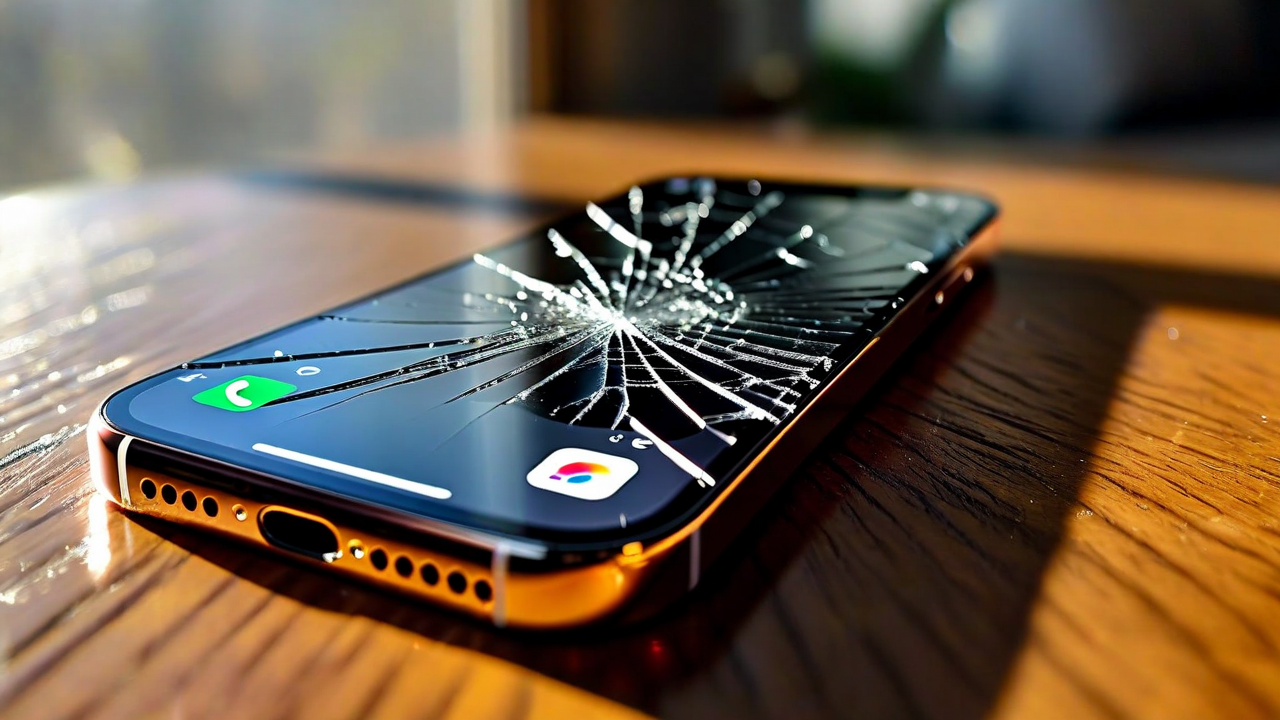

In [12]:
# Path to the damage photo
photo_path = "images/phone-001.png"

# Display the image
print("Damage Photo Evidence:")
display(Image(filename=photo_path, width=600))  # Adjust width as needed for clear visibility


### 3a. Detect Damage with Bounding Boxes

We use the [recommended object detection prompt template](https://docs.aws.amazon.com/nova/latest/nova2-userguide/prompting-multimodal.html) to detect cracks and damage. The model returns bounding box coordinates in `[x1, y1, x2, y2]` format, normalized to a 0–1000 coordinate space.

Model response: [0, 230, 790, 871].

Detected 1 damage region(s): [(0, 230, 790, 871)]


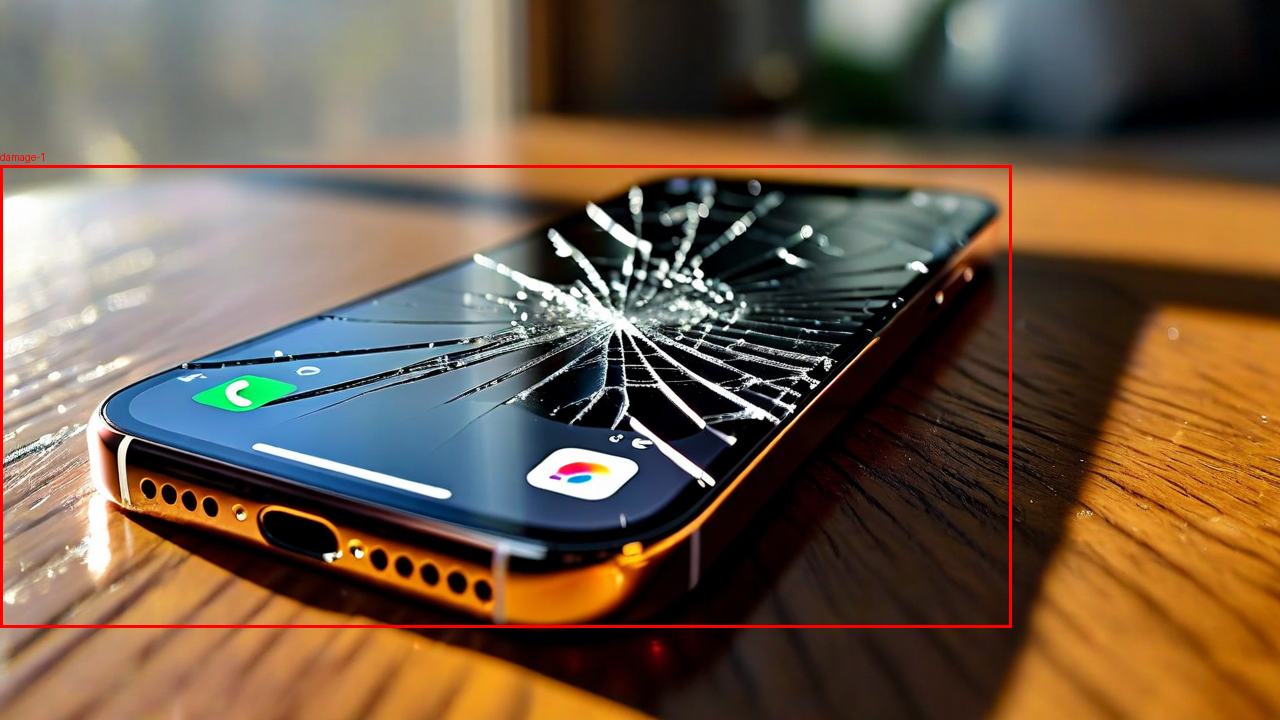

In [13]:
import re
from PIL import Image as PILImage, ImageDraw, ImageFont

def parse_coord_text(text):
    """Parses a model response which uses array formatting ([x, y, ...])
    to describe points and bounding boxes. Returns an array of tuples."""
    pattern = r"\[([^\[\]]*?)\]"
    return [
        tuple(int(x.strip()) for x in match.split(","))
        for match in re.findall(pattern, text)
    ]

def remap_bbox_to_image(bounding_box, image_width, image_height):
    """Remap normalized coordinates (0-1000) to actual image pixel coordinates."""
    return [
        bounding_box[0] * image_width / 1000,
        bounding_box[1] * image_height / 1000,
        bounding_box[2] * image_width / 1000,
        bounding_box[3] * image_height / 1000,
    ]

def detect_damage_bounding_boxes(photo_path, target_description="cracks, screen damage, and physical damage"):
    """
    Uses Nova's object detection to find damage in the photo and returns bounding boxes.
    Follows the recommended prompt template for detecting multiple instances with bounding boxes.
    """
    prompt = f"""Please identify {target_description} in the image and provide the bounding box coordinates for each one you detect. Represent the bounding box as the [x1, y1, x2, y2] format, where the coordinates are scaled between 0 and 1000 to the image width and height, respectively."""

    result = send_document_to_bedrock(
        prompt=prompt,
        model_id=MODEL_ID,
        file_path=photo_path,
        document_type="png"
    )
    if result:
        output_message = result.get("output", {}).get("message", {})
        for content in output_message.get("content", []):
            if "text" in content:
                print("Model response:", content["text"])
                return parse_coord_text(content["text"])
    return []

def draw_bounding_boxes(photo_path, bboxes, output_path=None):
    """
    Draws bounding boxes on the image and displays it.
    bboxes: list of tuples in normalized (0-1000) coordinates.
    """
    img = PILImage.open(photo_path)
    draw = ImageDraw.Draw(img)
    w, h = img.size

    for i, bbox in enumerate(bboxes):
        if len(bbox) == 4:
            coords = remap_bbox_to_image(bbox, w, h)
            draw.rectangle(coords, outline="red", width=3)
            draw.text((coords[0], max(0, coords[1] - 15)), f"damage-{i+1}", fill="red")

    if output_path:
        img.save(output_path)
    # Display in notebook
    display(img)
    return img

# Detect damage bounding boxes
photo_path = "images/phone-001.png"
bboxes = detect_damage_bounding_boxes(photo_path)
print(f"\nDetected {len(bboxes)} damage region(s): {bboxes}")

# Draw and display
if bboxes:
    annotated_img = draw_bounding_boxes(photo_path, bboxes)
else:
    print("No bounding boxes detected. Displaying original image.")
    display(Image(filename=photo_path, width=500))


### 3b. Validate Claim Data Against Photo Evidence

Compare the extracted claim data with the photo to assess whether the damage description aligns with the visual evidence. We use a JSON schema in the prompt following the recommended KIE best practice.

In [14]:
validation_json_schema = {
    "type": "object",
    "properties": {
        "device_identification": {
            "type": "object",
            "properties": {
                "value": {"type": "string", "enum": ["true", "false", "unclear"]},
                "rationale": {"type": "string"}
            },
            "required": ["value", "rationale"]
        },
        "damage_verification": {
            "type": "object",
            "properties": {
                "value": {"type": "string", "enum": ["true", "false", "unclear"]},
                "rationale": {"type": "string"}
            },
            "required": ["value", "rationale"]
        },
        "incident_consistency": {
            "type": "object",
            "properties": {
                "value": {"type": "string", "enum": ["true", "false", "unclear"]},
                "rationale": {"type": "string"}
            },
            "required": ["value", "rationale"]
        },
        "fraud_risk_score": {
            "type": "object",
            "properties": {
                "value": {"type": "number", "minimum": 0, "maximum": 1},
                "rationale": {"type": "string"}
            },
            "required": ["value", "rationale"]
        },
        "inconsistencies_detected": {
            "type": "object",
            "properties": {
                "value": {"type": "string", "enum": ["true", "false"]},
                "rationale": {"type": "string"}
            },
            "required": ["value", "rationale"]
        },
        "recommended_action": {
            "type": "string",
            "enum": ["pass to next step", "human review needed"]
        }
    },
    "required": [
        "device_identification",
        "damage_verification",
        "incident_consistency",
        "fraud_risk_score",
        "inconsistencies_detected",
        "recommended_action"
    ]
}

def validate_claim_with_photo(claim_data, photo_path):
    """
    Validates a claim against photo evidence using a JSON schema in the prompt.
    Returns the parsed validation dict.
    """
    schema_str = json.dumps(validation_json_schema, indent=2)

    prompt_text = f"""Analyze this damage photo against the claim details and extract a structured validation assessment in JSON format according to the given schema.

Follow these guidelines:
- Ensure that every field is populated. Only use null when the value cannot be determined.
- Based on the following criteria, determine the recommended_action:
  - If fraud_risk_score > 0.5, recommend "human review needed"
  - If any inconsistencies are detected, recommend "human review needed"
  - If device_identification or damage_verification is "false", recommend "human review needed"
  - Otherwise, recommend "pass to next step"
- For each assessment category, provide a clear, single-sentence rationale.

Claim Details:
- Device: {claim_data['device_information']['phone_make']} {claim_data['device_information']['phone_model']}
- Color: {claim_data['device_information']['color']}
- Storage: {claim_data['device_information']['storage_capacity_gb']}GB
- IMEI: {claim_data['device_information']['imei_number']}

Reported Incident:
- Damage Type: {claim_data['incident_details']['type_of_damage']}
- Description: {claim_data['incident_details']['damage_description']}

JSON Schema:
{schema_str}"""

    result = send_document_to_bedrock(
        prompt=prompt_text,
        model_id=MODEL_ID,
        file_path=photo_path,
        document_type="png"
    )
    if result:
        output_message = result.get("output", {}).get("message", {})
        for content in output_message.get("content", []):
            if "text" in content:
                try:
                    return extract_json_from_response(content["text"])
                except (json.JSONDecodeError, ValueError) as e:
                    print(f"Error parsing validation JSON: {e}")
                    print("Raw response:", content["text"][:500])
    return None


In [15]:
# Run validation on the first claim
claim_data = document_list[0]

validation_result = validate_claim_with_photo(claim_data, photo_path)

if validation_result:
    print("\nValidation Results:")
    pprint(validation_result)



Validation Results:
{'damage_verification': {'rationale': 'The image clearly shows extensive '
                                      'spider-web cracking on the screen, '
                                      "aligning with the reported 'Accidental "
                                      "Drop - Screen Damage' incident.",
                         'value': 'true'},
 'device_identification': {'rationale': 'The device matches the description of '
                                        'an Apple iPhone 14 Pro with a gold '
                                        'color, consistent with the claim '
                                        'details.',
                           'value': 'true'},
 'fraud_risk_score': {'rationale': 'There are no red flags indicating fraud; '
                                   'the damage and incident description are '
                                   'plausible and align with typical accident '
                                   'scenarios.',
              

## Conclusion

This notebook demonstrated how to use Amazon Nova 2 Lite for:

- Extracting structured data from PDF documents using JSON schemas in the prompt
- Detecting damage in photos with bounding box coordinates
- Cross-referencing claim form data with photo evidence for validation

For more details, see the [Multimodal Prompting Best Practices](https://docs.aws.amazon.com/nova/latest/nova2-userguide/prompting-multimodal.html).